# `metrics` module

> This module allows to compute commonly used pixel-wise semantic segmentation metrics easily. Moreover, it makes it possible to compute metrics over both shapes and rasters. Additionally, this model allows relaxing these metrics by applying a tolerance buffer.

### 1. Imports

In [1]:
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Import seg-eval package
import sys; sys.path.append('../')
from metrics import *
from visualization import *

### 2. Parametrization

In [2]:
data_path = '../test_data'

### 3. Pixel-wise semantic segmentation metrics (traditional approach, using rasters)

In [3]:
x = rasterio.open(f'{data_path}/23578960_15.tif').read() # Input image at 1m GSD
y = rasterio.open(f'{data_path}/23578960_15_y_true.tif').read() # Ground Truth at 1m GSD
y_hat = rasterio.open(f'{data_path}/23578960_15_y_pred.tif').read() # Predicted segmentation map at 2m GSD (directly outputed by the model)
y_hat_resc = rasterio.open(f'{data_path}/23578960_15_y_pred_resc.tif').read() # Predicted segmentation map at 1m GSD (after rescaling the logits)

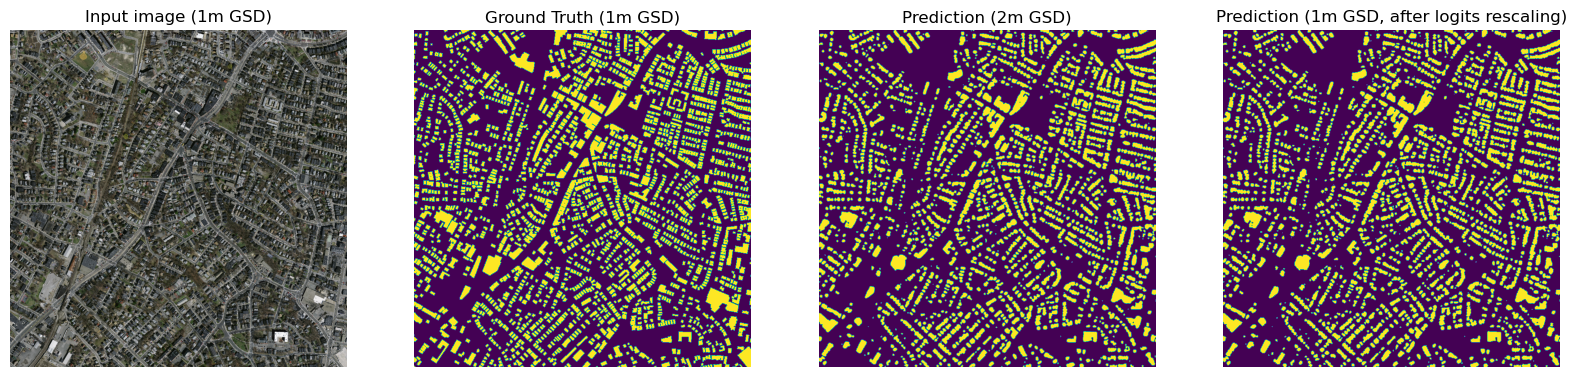

In [4]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(x.transpose(1, 2, 0)); ax[0].set_title('Input image (1m GSD)'); ax[0].axis('off')
ax[1].imshow(y[0]); ax[1].set_title('Ground Truth (1m GSD)'); ax[1].axis('off')
ax[2].imshow(y_hat[0]); ax[2].set_title('Prediction (2m GSD)'); ax[2].axis('off')
ax[3].imshow(y_hat_resc[0]); ax[3].set_title('Prediction (1m GSD, after logits rescaling)'); ax[3].axis('off')
plt.show()

In [5]:
# First compute confusion matrix terms
tp, tn, fp, fn = compute_confusion_matrix_np(y_hat_resc, y, buffer=None)

# Then compute semantic segmentation metrics
metrics = ['iou', 'dice', 'ppv', 'tpr', 'tnr', 'fpr', 'fnr', 'auc', 'kappa', 'mcc']
values = {m:eval(f'{m}({tp}, {tn}, {fp}, {fn})') for m in metrics}

# Show resulting metrics
raster_metrics_df = pd.DataFrame(values, index=[0])
raster_metrics_df

,iou,dice,ppv,tpr,tnr,fpr,fnr,auc,kappa,mcc
0,0.59863,0.748929,0.800558,0.703555,0.925019,0.074981,0.296445,0.814287,0.651148,0.653778


## 4. Pixel-wise semantic segmentation metrics (Suggested approach, using shapes)

In [6]:
# Get predicted segmentation map in vector format
with rasterio.open(f'{data_path}/23578960_15_y_pred_resc.tif') as src: 
    y_hat_resc_shp = np_to_shp(src.read(), transform=src.transform, crs=src.crs) 
    
# Load Ground Truth annotations in vector format (this is possible since the Massachusetts Buildings Dataset provides them, otherwise same procedure as for the predicted segmentation map should be followed)
y_shp = gpd.read_file(f'{data_path}/23578960_15_sub_gt_shapes.geojson')
y_shp = gpd.GeoDataFrame({'geometry': [y_shp.unary_union.buffer(0)]}, crs=y_shp.crs)

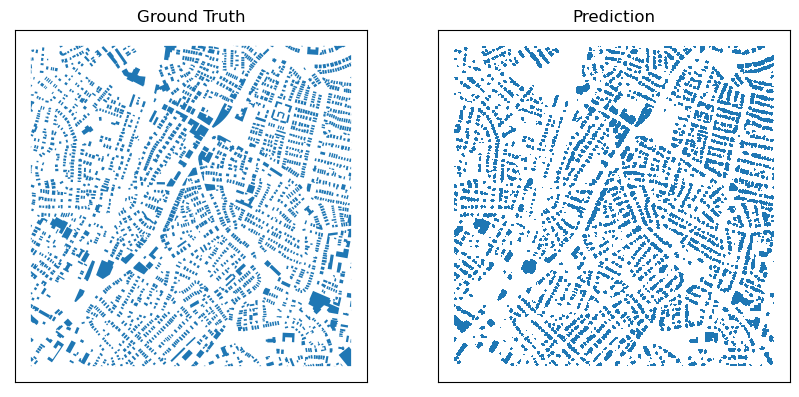

In [7]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
y_shp.plot(ax=ax[0]); ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].set_title('Ground Truth')
y_hat_resc_shp.plot(ax=ax[1]); ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].set_title('Prediction')
plt.show()

In [8]:
# First compute confusion matrix terms
tp, tn, fp, fn = compute_confusion_matrix_shp(y_hat_resc_shp, y_shp, buffer=None, boundary=None)

# Then compute semantic segmentation metrics
metrics = ['iou', 'dice', 'ppv', 'tpr', 'tnr', 'fpr', 'fnr', 'auc', 'kappa', 'mcc']
values = {m:eval(f'{m}({tp}, {tn}, {fp}, {fn})') for m in metrics}

# Show resulting metrics
shape_metrics_df = pd.DataFrame(values, index=[0])
shape_metrics_df

,iou,dice,ppv,tpr,tnr,fpr,fnr,auc,kappa,mcc
0,0.52164,0.685629,0.62132,0.764786,0.873155,0.126845,0.235214,0.81897,0.588488,0.593964


### 5. Raster vs. Shape metric comparison

In [9]:
metrics_df = pd.concat([raster_metrics_df, shape_metrics_df])
metrics_df.set_index(pd.Index(['raster', 'shape']))

,iou,dice,ppv,tpr,tnr,fpr,fnr,auc,kappa,mcc
raster,0.59863,0.748929,0.800558,0.703555,0.925019,0.074981,0.296445,0.814287,0.651148,0.653778
shape,0.52164,0.685629,0.621320,0.764786,0.873155,0.126845,0.235214,0.818970,0.588488,0.593964


In [10]:
# Depending on the metric there are significant differences between both modes. This is due to the floating precision of vectors.

### 6. Metric Relaxation

In [11]:
# Get predicted segmentation map in vector format
with rasterio.open(f'{data_path}/23578960_15_y_pred_resc.tif') as src: 
    y_hat_resc_shp = np_to_shp(src.read(), transform=src.transform, crs=src.crs) 
    
# Load Ground Truth annotations in vector format (this is possible since the Massachusetts Buildings Dataset provides them, otherwise same procedure as for the predicted segmentation map should be followed)
y_shp = gpd.read_file(f'{data_path}/23578960_15_sub_gt_shapes.geojson')
y_shp = gpd.GeoDataFrame({'geometry': [y_shp.unary_union.buffer(0)]}, crs=y_shp.crs)

In [12]:
# Get the corresponding buffer. The buffer size has been set as suggested in the paper. Recall that the predicted segmentation map is at 2 m GSD
res = 2 
buffer = (2 * res ** 2) ** .5
buff = get_buffer_shp(y_shp, buffer, kind='outer')

<AxesSubplot:>

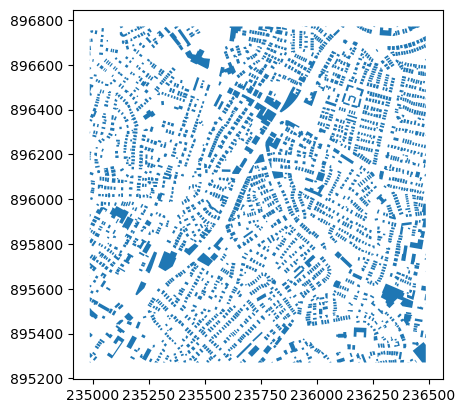

In [13]:
y_shp.plot()

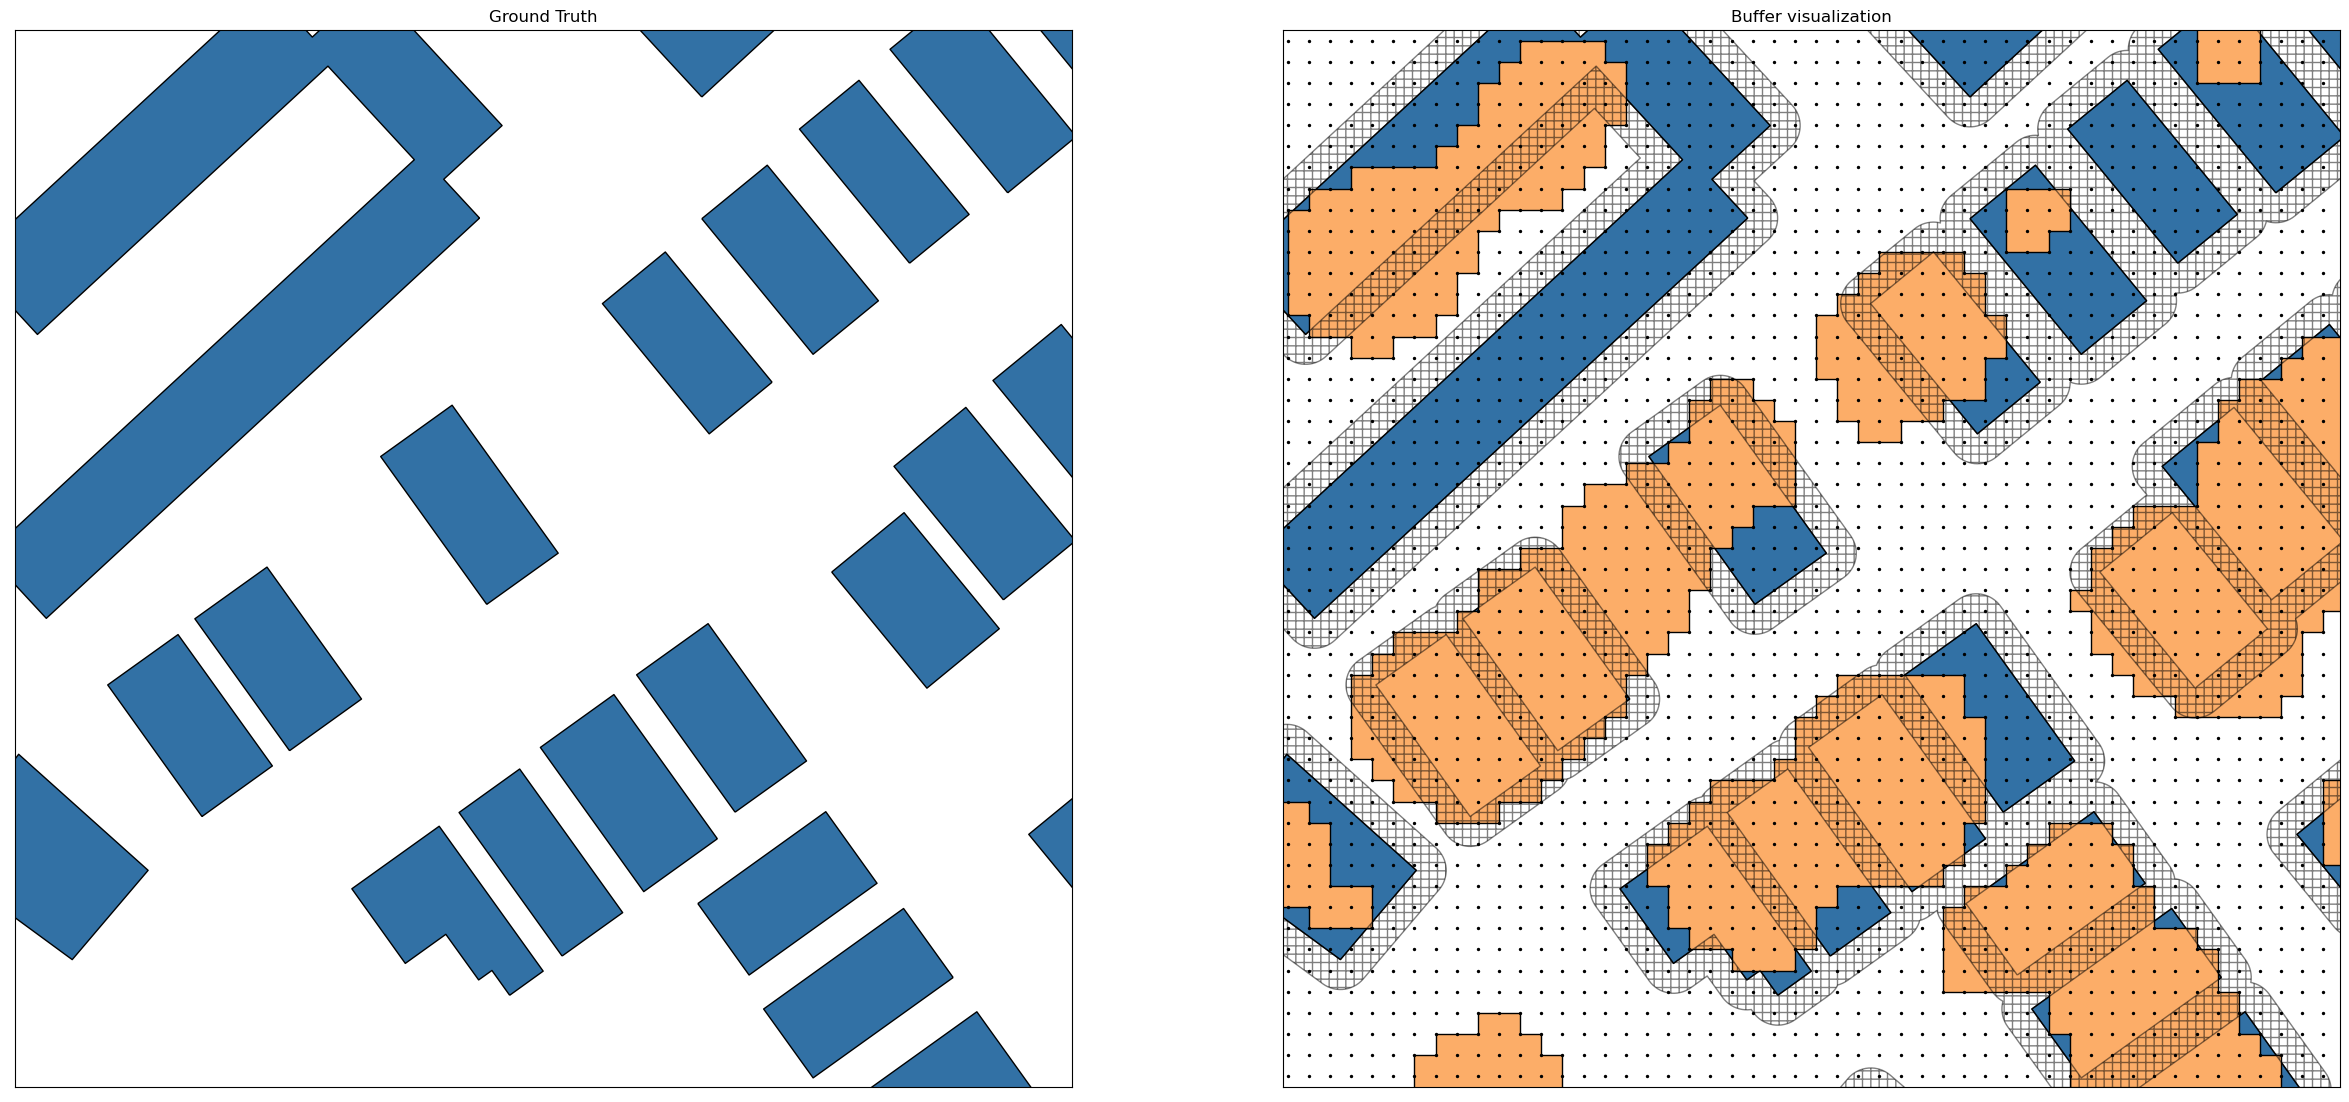

In [14]:
# Get the boundary
boundary = get_boundary(y_shp)

# Manually define a window to zoom in
minX, minY, maxX, maxY = 235900, 895600, 236000, 895700 

# Show the (left) the Ground Truth annotations, and (right) the Ground Truth (in blue), the predictions (in orange), and buffer (in a hatched black 
# pattern)

f, ax = plt.subplots(1, 2, figsize=(30, 15))

# Left figure
y_shp.plot(ax=ax[0], color='#3271a5', edgecolor='black')
ax[0].set_xlim(minX, maxX); ax[0].set_ylim(minY, maxY); ax[0].set_title('Ground Truth'); ax[0].set_xticks([]); ax[0].set_yticks([])
    
# Right figure
y_shp.plot(ax=ax[1], color='#3271a5', edgecolor='black') # Ground Truth
y_hat_resc_shp.plot(ax=ax[1], color='#fcad68', edgecolor='black') # Prediction
gpd.GeoDataFrame({'geometry': [buff]}, crs=y_shp.crs).plot(ax=ax[1], color='none', alpha=.5, edgecolor='black', hatch='++') # Buffer
ax[1].set_xlim(minX, maxX); ax[1].set_ylim(minY, maxY); ax[1].set_title('Buffer visualization'); ax[1].set_xticks([]); ax[1].set_yticks([])

# Optionally generate a point grid to ease visualization of GSD
grid = gen_grid(outer_bounds=boundary.bounds, inner_bounds=(minX, minY, maxX, maxY), crs=y_shp.crs, gsd=res)
grid.plot(ax=ax[1], color='black', edgecolor='black', markersize=2)

plt.show()

In [15]:
# First compute confusion matrix terms
tp, tn, fp, fn = compute_confusion_matrix_shp(y_hat_resc_shp, y_shp, buffer=buff, boundary=None)

# Then compute semantic segmentation metrics
metrics = ['iou', 'dice', 'ppv', 'tpr', 'tnr', 'fpr', 'fnr', 'auc', 'kappa', 'mcc']
values = {m:eval(f'{m}({tp}, {tn}, {fp}, {fn})') for m in metrics}

# Show resulting metrics
shape_metrics_buff_df = pd.DataFrame(values, index=[0])
shape_metrics_buff_df

,iou,dice,ppv,tpr,tnr,fpr,fnr,auc,kappa,mcc
0,0.690532,0.81694,0.876729,0.764786,0.961457,0.038543,0.235214,0.863121,0.757259,0.760374


In [16]:
metrics_df = pd.concat([shape_metrics_df, shape_metrics_buff_df])
metrics_df.set_index(pd.Index(['w/o buff', 'w/ buff']))

,iou,dice,ppv,tpr,tnr,fpr,fnr,auc,kappa,mcc
w/o buff,0.521640,0.685629,0.621320,0.764786,0.873155,0.126845,0.235214,0.818970,0.588488,0.593964
w/ buff,0.690532,0.816940,0.876729,0.764786,0.961457,0.038543,0.235214,0.863121,0.757259,0.760374


In [17]:
# When errors caused by the limited spatial resolution, such as those that may occur due to the rasterization process at the edges of objects 
# are ignored metrics increase.

### 7. Visualizing Intersection over Union maps using the `visualization` module

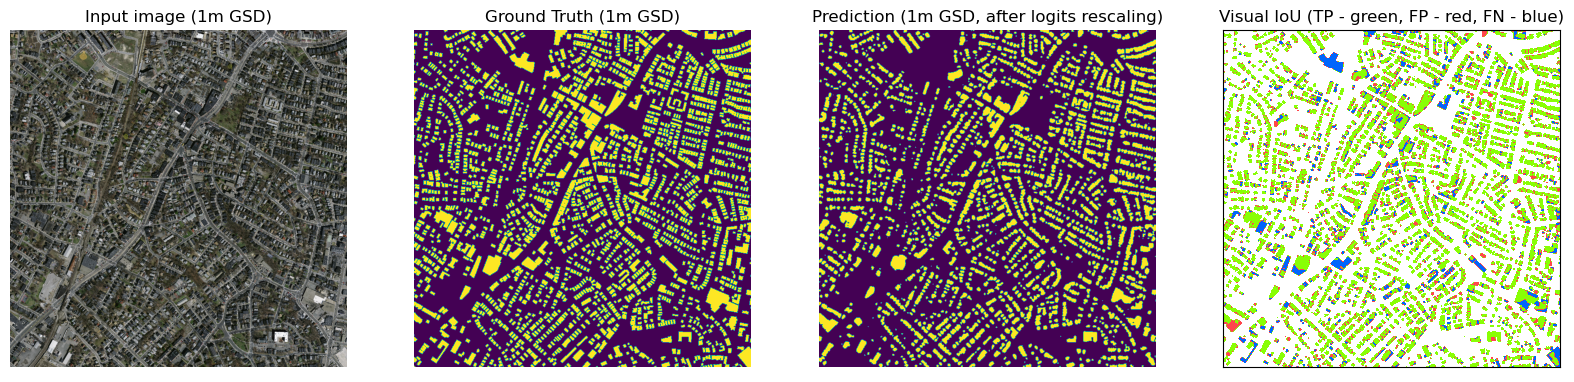

In [29]:
# For camputing the visual IoU we need the Ground Truth and predicted segmentation map in raster format.
iou, iou_cmap = get_iou_mask(y_hat_resc, y)

f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(x.transpose(1, 2, 0)); ax[0].set_title('Input image (1m GSD)'); ax[0].axis('off')
ax[1].imshow(y[0]); ax[1].set_title('Ground Truth (1m GSD)'); ax[1].axis('off')
ax[2].imshow(y_hat_resc[0]); ax[2].set_title('Prediction (1m GSD, after logits rescaling)'); ax[2].axis('off')
ax[3].imshow(iou[0], cmap=iou_cmap, vmin=0, vmax=3); ax[3].set_xticks([]); ax[3].set_yticks([]); ax[3].set_title('Visual IoU (TP - green, FP - red, FN - blue)')
plt.show()